In [1]:
cd ../

/Users/ngriffiths/Deep_Learning_Name_Creation


In [11]:
import joblib
import torch
from typing import *
import numpy as np
import torch.nn as nn
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from utils.dataloader import CharDataLoader
random.seed(0)

In [3]:
names = list(joblib.load('data/names.pkl')['names'])
random.shuffle(names)
train_names = names[0:round(.7*len(names))]
val_names = names[round(.7*len(names)):]

In [4]:
train_dataloader = CharDataLoader(text_list=train_names,
                                  batch_size=100,
                                  shuffle=True,
                                  pad_char='!',
                                  return_y=True)
ix_to_char = train_dataloader.ix_to_char

val_dataloader = CharDataLoader(text_list=train_names,
                                batch_size=100,
                                shuffle=False,
                                pad_char='!',
                                return_y=True,
                                ix_to_char=ix_to_char)

In [5]:
# Build basic RNN

class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, pad, dropout=.2):
        super(RNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, pad)
        self.rnn = nn.RNN(embed_dim, 20, 2, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(20, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.embed(x)
        x, h_n = self.rnn(x)
        x = nn.functional.relu(self.fc(x))
        return x.view(x.shape[0], x.shape[2], -1)
        

In [17]:
def train(model,
          optimizer,
          train_dataloader: CharDataLoader,
          val_dataloader: CharDataLoader,
          criterion=nn.CrossEntropyLoss(),
          n_iter: int=10,
          early_stopping_rounds: int=5,
          save_model: bool=False,
          model_path: str='models/model.pkl'):
    
    train_losses = list()
    val_losses = list()
    
    best_val_loss = np.inf
    no_imp = 0
    
    for it in range(1, n_iter+1):
        
        train_loss = list()
        val_loss = list()
            
        model.train()
        for x_batch, y_batch in train_dataloader:
            model.zero_grad()

            y_pred = model(x_batch)

            loss = criterion(y_pred, y_batch)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_dataloader:
                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                val_loss.append(loss.item())
        
        print(f'\nEpoch {it} Train Loss: {np.mean(train_loss)}')
        print(f'Epoch {it} Val Loss: {np.mean(val_loss)}')
        train_losses.append(np.mean(train_loss))
        val_losses.append(np.mean(val_loss))
        
        if np.mean(val_loss) < best_val_loss:
            no_imp = 0
            best_val_loss = np.mean(val_loss)
            print('New best score...')
            if save_model:
                print('Saving Model...')
                torch.save(model.state_dict(), model_path)
        
        else:
            no_imp += 1
            if no_imp == early_stopping_rounds:
                print(f'No improvement for {early_stopping_rounds} rounds. Ending training.')
                break
        
    return train_losses, val_losses

In [18]:
model = RNN(vocab_size=len(ix_to_char),
            embed_dim=20,
            pad=train_dataloader.char_to_ix['!'],
            dropout=0.15)

optimizer = torch.optim.Adam(model.parameters(), lr=.005)

In [19]:
train_losses, val_losses = train(model=model,
                                 optimizer=optimizer,
                                 train_dataloader=train_dataloader,
                                 val_dataloader=val_dataloader,
                                 n_iter=200,
                                 early_stopping_rounds=15,
                                 model_path= 'models/basic_rnn.pkl')


Epoch 1 Train Loss: 3.115406820839825
Epoch 1 Val Loss: 2.982935177397486
New best score...

Epoch 2 Train Loss: 2.9577523703499007
Epoch 2 Val Loss: 2.9254331336139074
New best score...

Epoch 3 Train Loss: 2.865630407983921
Epoch 3 Val Loss: 2.876963924081301
New best score...

Epoch 4 Train Loss: 2.8360191739349476
Epoch 4 Val Loss: 2.794061696408276
New best score...

Epoch 5 Train Loss: 2.7755693801082617
Epoch 5 Val Loss: 2.771433458618917
New best score...

Epoch 6 Train Loss: 2.775546441749495
Epoch 6 Val Loss: 2.765557023368138
New best score...

Epoch 7 Train Loss: 2.7242846902465265
Epoch 7 Val Loss: 2.7540205075190616
New best score...

Epoch 8 Train Loss: 2.736574184565828
Epoch 8 Val Loss: 2.7212795477647047
New best score...

Epoch 9 Train Loss: 2.7167087763937188
Epoch 9 Val Loss: 2.715291813599873
New best score...

Epoch 10 Train Loss: 2.7051165629886578
Epoch 10 Val Loss: 2.7113568827791035
New best score...

Epoch 11 Train Loss: 2.721199238594454
Epoch 11 Val Loss:


Epoch 100 Train Loss: 2.611369893582016
Epoch 100 Val Loss: 2.59765811997678

Epoch 101 Train Loss: 2.5903140555618465
Epoch 101 Val Loss: 2.6278318490276145

Epoch 102 Train Loss: 2.594527077086605
Epoch 102 Val Loss: 2.6211602772614433

Epoch 103 Train Loss: 2.6152977259999957
Epoch 103 Val Loss: 2.616051958330484

Epoch 104 Train Loss: 2.5973056700129296
Epoch 104 Val Loss: 2.588735278355193

Epoch 105 Train Loss: 2.579094362189704
Epoch 105 Val Loss: 2.6222849475282026

Epoch 106 Train Loss: 2.6213155183805954
Epoch 106 Val Loss: 2.6136524462734494

Epoch 107 Train Loss: 2.609292593853567
Epoch 107 Val Loss: 2.624272648585725
No improvement for 15 rounds. Ending training.


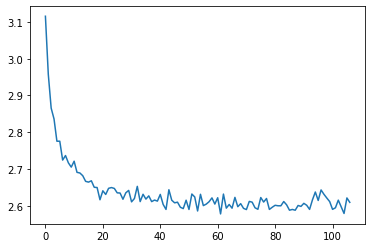

In [20]:
plt.plot(train_losses)

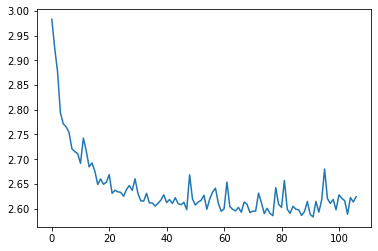

In [21]:
plt.plot(val_losses)